In [0]:
# Filtado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

#Para la realización de esta actividad se hizo uso de [material](https://jdvelasq.github.io/courses/notebooks/sklearn/bayes/02-filtrado-de-mensajes-sms.html) facilitado por docente

# Procesamiento de los datos

In [110]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, mean_squared_error, confusion_matrix, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn import linear_model
import random

%matplotlib inline
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Carga de los datos

In [0]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/jdvelasq/datalabs/master/datasets/sms-spam.csv",
    sep = ',',
    thousands = None,
    decimal = '.',
    encoding='latin-1')

In [6]:
df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Conteo de la cantidad de mensajes por tipo

In [7]:
df.type.value_counts()

ham     4827
spam     747
Name: type, dtype: int64

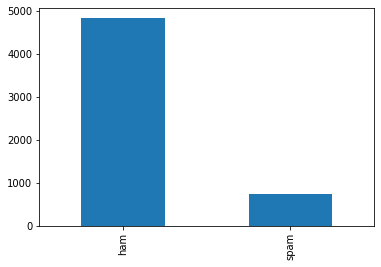

In [9]:
df.type.value_counts().plot.bar();

In [13]:
## Se convierte el conteo anterior en probabilidades.
round(100 * df.type.value_counts() / sum(df.type.value_counts()), 1)

ham     86.6
spam    13.4
Name: type, dtype: float64

#Uso de Bag of Words

##Steemer

In [18]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

df['stemmed'] = df.text.apply(lambda x: ' '.join([stemmer.stem(w) for w in x.split() ]))

df.head(6)

,type,text,stemmed
0,ham,"Go until jurong point, crazy.. Available only ...","Go until jurong point, crazy.. avail onli in b..."
1,ham,Ok lar... Joking wif u oni...,Ok lar... joke wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entri in 2 a wkli comp to win FA cup fina...
3,ham,U dun say so early hor... U c already then say...,U dun say so earli hor... U c alreadi then say...
4,ham,"Nah I don't think he goes to usf, he lives aro...","nah I don't think he goe to usf, he live aroun..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...,freemsg hey there darl it' been 3 week' now an...


##Matriz de términos del documento

In [34]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(
    analyzer='word',        # a nivel de palabra
    lowercase=True,         # convierte a minúsculas
    stop_words='english',   # stop_words en inglés
    binary=True,            # Los valores distintos de cero son fijados en 1
    min_df=5                # ignora palabras con baja frecuencia
)
 
## Aplica la función al texto
dtm = count_vect.fit_transform(df.stemmed)

## Las filas contienen los mensajes
## y las clomunas los términos
dtm.shape

(5574, 1540)

In [35]:
## Palabras aprendidas de los mensajes de texto
vocabulary = count_vect.get_feature_names()

## Primeras palabras del vocabulario
vocabulary[0:10]

['00',
 '000',
 '02',
 '03',
 '04',
 '06',
 '0800',
 '08000839402',
 '08000930705',
 '0870']

Textos modificados con las palabras reducidas a sus bases, sin conjugar y sin artículos

In [36]:
def dtm2words(dtm, vocabulary, index):
    as_list = dtm[index,:].toarray().tolist()
    docs = []
    for i in index:
        k = [vocabulary[iword] for iword, ifreq in enumerate(as_list[i]) if ifreq > 0]
        docs += [k]
    return docs

for i, x in enumerate(dtm2words(dtm, vocabulary, [0, 1, 2, 3, 4, 5])):
    print('Org: ', df.text[i])
    print('Mod: ', ' '.join(x))
    print('')

Org:  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Mod:  avail bugi cine got great la onli point wat world

Org:  Ok lar... Joking wif u oni...
Mod:  joke lar ok wif

Org:  Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Mod:  appli comp cup entri final free question rate receiv std text txt win wkli

Org:  U dun say so early hor... U c already then say...
Mod:  alreadi dun earli say

Org:  Nah I don't think he goes to usf, he lives around here though
Mod:  don goe live nah think usf

Org:  FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv
Mod:  50 darl freemsg fun hey like ok send std week word xxx



# Regresión logística

Dividir los datos en conjuntos de prueba y entrenamiento

In [0]:
X_train      = dtm[0:4168,]
X_test       = dtm[4169:,]
y_train_true = df.type[0:4168]
y_test_true  = df.type[4169:]

Regresióm logística

In [0]:
#Regresión Logística con sklearn
regresion_logistica = linear_model.LogisticRegression()
regresion_logistica.fit(X_train,y_train_true)
y_pred_train = regresion_logistica.predict(X_train)

## Métrica de desempeño de la regresión logística

### Errores de prueba y entrenamiento

Veamos qué tanto se equivoca el modelo de regresión logística en el conjunto de datos sobre el que ha sido entrendo

In [54]:
efectividad_entrenamiento = accuracy_score(y_train_true, y_pred_train)
print("Error de entrenamiento = " + str(1 - efectividad_entrenamiento))

Error de entrenamiento = 0.008157389635316648


Se comporta muy bien, tiene un error menor a 1%! Aunque es posible que esté sobreentrenado, veamos de qué manera se comporta cuando se le prueba en datos que nunca ha visto:

In [55]:
y_pred_test = regresion_logistica.predict(X_test)
efectividad_pruebas = accuracy_score(y_test_true, y_pred_test)
print("Error de pruebas: " + str(1 - efectividad_pruebas))

Error de pruebas: 0.019217081850533835


Su precisión a penas se ve alterada, ahora el error es menor al 2%. Sigue siendo muy bueno.

### Matriz de confusión (Sobre el conjunto de test)

In [66]:
matriz_confusion = confusion_matrix(y_test_true, y_pred_test, labels=["spam", "ham"])

# Para mostrar de mejor forma la matriz
table = pd.DataFrame(matriz_confusion)
table.columns = ["verdadero SPAM", "verdadero HAM"]
table.index = ["SPAM predicho", "HAM predicho"]
print(table)

               verdadero SPAM  verdadero HAM
SPAM predicho             157             26
HAM predicho                1           1221


In [0]:
VN, FP, FN, VP = matriz_confusion.ravel()

### Precisión del modelo:

$$P = \frac{VerdaderoHAM}{VerdaderoHAM + FalsoHAM}$$

Probabilidad de que el modelo no marque como HAM, una SPAM.

In [67]:
P = VP/(VP+FP)
print("La precisión del modelo para HAM es: " + str(P))

La precisión del modelo para HAM es: 0.9791499599037691


### Sensibilidad(Recall) del modelo:

$$R = \frac{VerdaderoHAM}{VerdaderoHAM + FalsoSPAM}$$

Capacidad del modelo de encontrar los HAMs.

In [69]:
R = VP/(VP+FN)
print("La sensibilidad del modelo es: " + str(R))

La sensibilidad del modelo es: 0.9991816693944353


### Especificidad del modelo:

$$E = \frac{VerdaderoSPAM}{VerdaderoSPAM + FalsoHAM}$$

Capacidad del modelo de encontrar elementos SPAM.

In [70]:
E = VN/(VN+FP)
print("La especificidad del modelo es: " + str(E))

La especificidad del modelo es: 0.8579234972677595


### F1 Score:



$$F1\_score = \frac{2 * P * R}{P + R}$$

Promedio entre precisión y sensibilidad, que da igual importancia a ambos valores.


In [71]:
F = (2*P*R)/(P+R)
print("El F1-Score del modelo es: " + str(F))

El F1-Score del modelo es: 0.9890643985419197


# Red neuronal

In [0]:
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.neural_network import MLPClassifier


La elección del número de neuronas en la capa oculta se hará por el F1 Score, que da igual importancia a la precisión y sensibilidad.

In [119]:
F_scores = []
for numero_neuronas in [4,5,6,7,8]: #Las opciones de neuronas son pocas, porque con muchas se demoraba una eternidad

  model = MLPClassifier(
              hidden_layer_sizes=(numero_neuronas,),
              activation='logistic',
              solver='sgd',
              learning_rate='adaptive',
              random_state= 666,
              max_iter=1000
          )

  model.fit(X_train,y_train_true)
  y_pred_ANN = model.predict(X_test)

  matriz_confusion = confusion_matrix(y_test_true, y_pred_ANN, labels=["spam", "ham"])
  VN, FP, FN, VP = matriz_confusion.ravel()
  P = VP/(VP+FP)
  R = VP/(VP+FN)
  F = (2*P*R)/(P+R)
  F_scores.append(F)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

In [122]:
print([4,5,6,7,8])
F_scores

[4, 5, 6, 7, 8]


[0.9760000000000001,
 0.9802975472456775,
 0.9842551473556722,
 0.9303387894937191,
 0.9834610730133118]

ERROR! Session/line number was not unique in database. History logging moved to new session 62


Vemos que de entre los modelos selesccionados, el que se comportó mejor es el que tiene 6 neuronas.

> Indented block



#Validación cruzada

In [0]:
model = MLPClassifier(
              hidden_layer_sizes=(6,),
              activation='logistic',
              solver='sgd',
              learning_rate='adaptive',
              random_state= 666,
              max_iter=1000
          )

In [125]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train_true, cv=5)
scores

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarni

array([0.96043165, 0.95083933, 0.96043165, 0.95798319, 0.95678271])

Viendo que después de la validación cruzada, el clasificador mantiene su F1Score por encima de 95, se evidencia que el modelo es robusto

In [127]:
model.fit(X_train,y_train_true)
y_pred_ANN = model.predict(X_test)

matriz_confusion = confusion_matrix(y_test_true, y_pred_ANN, labels=["spam", "ham"])

# Para mostrar de mejor forma la matriz
table = pd.DataFrame(matriz_confusion)
table.columns = ["verdadero SPAM", "verdadero HAM"]
table.index = ["SPAM predicho", "HAM predicho"]
print(table)

               verdadero SPAM  verdadero HAM
SPAM predicho             145             38
HAM predicho                3           1219


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [0]:
VN, FP, FN, VP = matriz_confusion.ravel()

### Precisión del modelo:

$$P = \frac{VerdaderoHAM}{VerdaderoHAM + FalsoHAM}$$

Probabilidad de que el modelo no marque como HAM, una SPAM.

In [131]:
P = VP/(VP+FP)
print("La precisión del modelo para HAM es: " + str(P))

La precisión del modelo para HAM es: 0.9697692919649961


### Sensibilidad(Recall) del modelo:

$$R = \frac{VerdaderoHAM}{VerdaderoHAM + FalsoSPAM}$$

Capacidad del modelo de encontrar los HAMs.

In [132]:
R = VP/(VP+FN)
print("La sensibilidad del modelo es: " + str(R))

La sensibilidad del modelo es: 0.997545008183306


### Especificidad del modelo:

$$E = \frac{VerdaderoSPAM}{VerdaderoSPAM + FalsoHAM}$$

Capacidad del modelo de encontrar elementos SPAM.

In [133]:
E = VN/(VN+FP)
print("La especificidad del modelo es: " + str(E))

La especificidad del modelo es: 0.7923497267759563


### F1 Score:



$$F1\_score = \frac{2 * P * R}{P + R}$$

Promedio entre precisión y sensibilidad, que da igual importancia a ambos valores.


In [134]:
F = (2*P*R)/(P+R)
print("El F1-Score del modelo es: " + str(F))

El F1-Score del modelo es: 0.9834610730133118


# Comparación

Tanto el modelo de regresión logística como el modelo de la red neuronal se comportaron muy bien. En cuanto a la especificidad de los modelos, ambos estuvieron un poco debajo del resto de las métricas usadas para juzgarlos, además, el modelo de regresión logística se comportó notablemente mejor en esa métrica.